In [90]:
from __future__ import annotations
from pymatgen.io.vasp import Kpoints
import numpy as np

from pymatgen.core import Structure

def _bump_up_kpoints(
    kpoints : Kpoints | dict,
    structure : Structure,
    factor : float = 0.2,
    max_inc : int = 100,
    min_kpoints : int | None = None
) -> dict:
    """
    Inputs:
        kpoints (Kpoints or dict) : original Kpoints used in the calculation
        structure (Structure) : associated structure
        factor (float) : factor used to increase k-point density.
            The first increase uses approximately (1 + factor) higher k-point density.
            The second increase: ~ (1 + 2*factor) higher k-kpoint density, etc.
        max_inc (int) : the maximum permitted increases in k-point density 
            before giving up
        min_kpoints (int or None): if an int, the minimum permitted number of 
            k-points. Could be useful if using the tetrahedron method, where
            at least 4 k-points are needed.
    Outputs:
        dict : the new Kpoints object as a dict
    """

    if isinstance(kpoints,Kpoints):
        kpoints = kpoints.as_dict()
    orig_num_kpoints = np.prod(kpoints["kpoints"][0])
    is_gamma_centered = kpoints.get("generation_style","Gamma").lower() == "gamma"

    # try to approximate k-points per reciprocal atom used in pymatgen
    lengths = structure.lattice.abc
    mult = max([nk*lengths[ik] for ik, nk in enumerate(kpoints["kpoints"][0])])
    ngrid = mult**3/np.prod(lengths)
    kppa = len(structure)*ngrid

    mult_fac = 1. + factor
    for _ in range(max_inc):

        new_kpoints = Kpoints.automatic_density(
            structure,
            mult_fac*kppa,
            force_gamma = is_gamma_centered
        )

        min_kpoints = min_kpoints or 1
        if (new_num_kpoints := np.prod(new_kpoints.kpts[0]) ) > orig_num_kpoints and (
            new_num_kpoints > min_kpoints
        ):
            break
        
        mult_fac += factor

    return new_kpoints.as_dict()

In [89]:
s = Structure.from_file("/Users/aaronkaplan/Library/CloudStorage/Dropbox/postdoc_MP/software/custodian_tet/tests/files/CONTCAR")
k = Kpoints.automatic_density(s,100)
_bump_up_kpoints(k,s)["kpoints"], k.kpts

3 70.82339993423021


([(3, 2, 1)], [(3, 1, 1)])

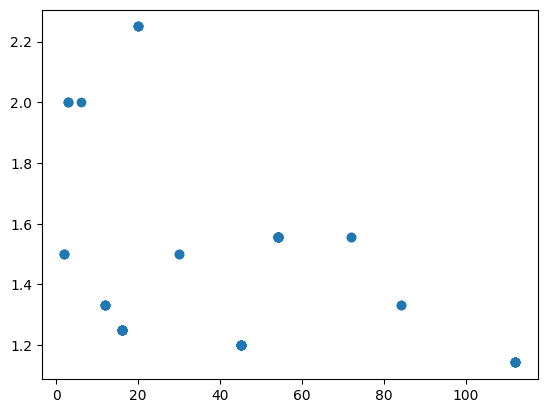

In [86]:
import matplotlib.pyplot as plt

rds = np.arange(50,1000,10)
og = np.zeros(len(rds))
new = np.zeros(len(rds))
for ird, rd in enumerate(rds):
    old_k = Kpoints.automatic_density(s,rd)
    new_k = _bump_up_kpoints(old_k,s)
    og[ird] = np.prod(old_k.kpts[0])
    new[ird] = np.prod(new_k["kpoints"][0])
plt.scatter(og,new/og)

In [87]:
new/og

array([1.5       , 1.5       , 1.5       , 2.        , 2.        ,
       2.        , 2.        , 1.33333333, 1.33333333, 1.33333333,
       1.33333333, 1.33333333, 1.25      , 1.25      , 1.25      ,
       1.25      , 1.25      , 1.25      , 1.25      , 1.25      ,
       1.25      , 1.25      , 1.25      , 1.25      , 1.25      ,
       1.25      , 1.25      , 1.25      , 2.25      , 2.25      ,
       2.25      , 2.25      , 1.5       , 1.5       , 1.2       ,
       1.2       , 1.2       , 1.2       , 1.2       , 1.2       ,
       1.2       , 1.2       , 1.2       , 1.2       , 1.2       ,
       1.2       , 1.2       , 1.2       , 1.2       , 1.2       ,
       1.2       , 1.2       , 1.55555556, 1.55555556, 1.55555556,
       1.55555556, 1.55555556, 1.55555556, 1.55555556, 1.55555556,
       1.55555556, 1.55555556, 1.55555556, 1.55555556, 1.55555556,
       1.55555556, 1.55555556, 1.55555556, 1.55555556, 1.55555556,
       1.55555556, 1.55555556, 1.55555556, 1.55555556, 1.55555